In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'

In [2]:
# Parameters
id_ = "Zilionis_Klein_2019_NSCLC"


# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 32073 × 36896
    obs: 'sample', 'gsm', 'tissue', 'sex', 'age', 'characteristics_ch1.7.treatment received prior to surgery (1= treated; 0=untreated)', 'patient', 'condition', 'origin', 'platform', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Types from infercnv dir

In [5]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types = types.rename(columns={'Unnamed: 0':'barcode_'})
types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
types

,barcode_,cell_type
0,bcEAPU_0,Lymphoid
1,bcFTPA_0,Airway epithelium
2,bcEBDX_0,Alveolar epithelium
3,bcFPHC_0,Airway epithelium
4,bcCLVG_0,Fibroblast lineage
...,...,...
32068,bcBOGU_25,Lymphoid
32069,bcHDOT_25,Airway epithelium
32070,bcIFTF_25,Lymphoid
32071,bcBDLT_25,Lymphoid


In [6]:
adata.obs['barcode_'] = adata.obs.index
adata.obs = pd.merge(adata.obs, types, on='barcode_',
                    how='left')
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

Index(['sample', 'gsm', 'tissue', 'sex', 'age',
       'characteristics_ch1.7.treatment received prior to surgery (1= treated; 0=untreated)',
       'patient', 'condition', 'origin', 'platform', 'n_counts', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'barcode_', 'cell_type'],
      dtype='object')

### Tumor prediction from ikarus

In [7]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
preds

,Unnamed: 0,final_pred
0,0,Normal
1,1,Normal
2,2,Normal
3,3,Normal
4,4,Normal
...,...,...
32068,32068,Normal
32069,32069,Normal
32070,32070,Normal
32071,32071,Normal


In [8]:
adata.obs['final_pred'] = list(preds.iloc[:,1])

In [9]:
adata.obs['origin']

0        tumor_primary
1        tumor_primary
2        tumor_primary
3        tumor_primary
4        tumor_primary
             ...      
32068    tumor_primary
32069    tumor_primary
32070    tumor_primary
32071    tumor_primary
32072    tumor_primary
Name: origin, Length: 32073, dtype: category
Categories (1, object): ['tumor_primary']

In [10]:
adata[np.logical_or(adata.obs['origin'].str.contains('normal'), adata.obs['origin']=='tumor_primary')].obs['origin'].value_counts()

origin
tumor_primary    32073
Name: count, dtype: int64

In [11]:
adata.layers['counts'] = adata.X

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [13]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)

2024-01-26 05:35:09.944545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 05:35:09.944602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 05:35:09.945900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 05:35:09.953814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-01-26 05:35:12.786384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/usr/local/lib/python3.11/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/usr/local/lib/python3.11/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/usr/local/lib/python3.11/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numb

In [14]:
sc.tl.umap(adata)

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ign

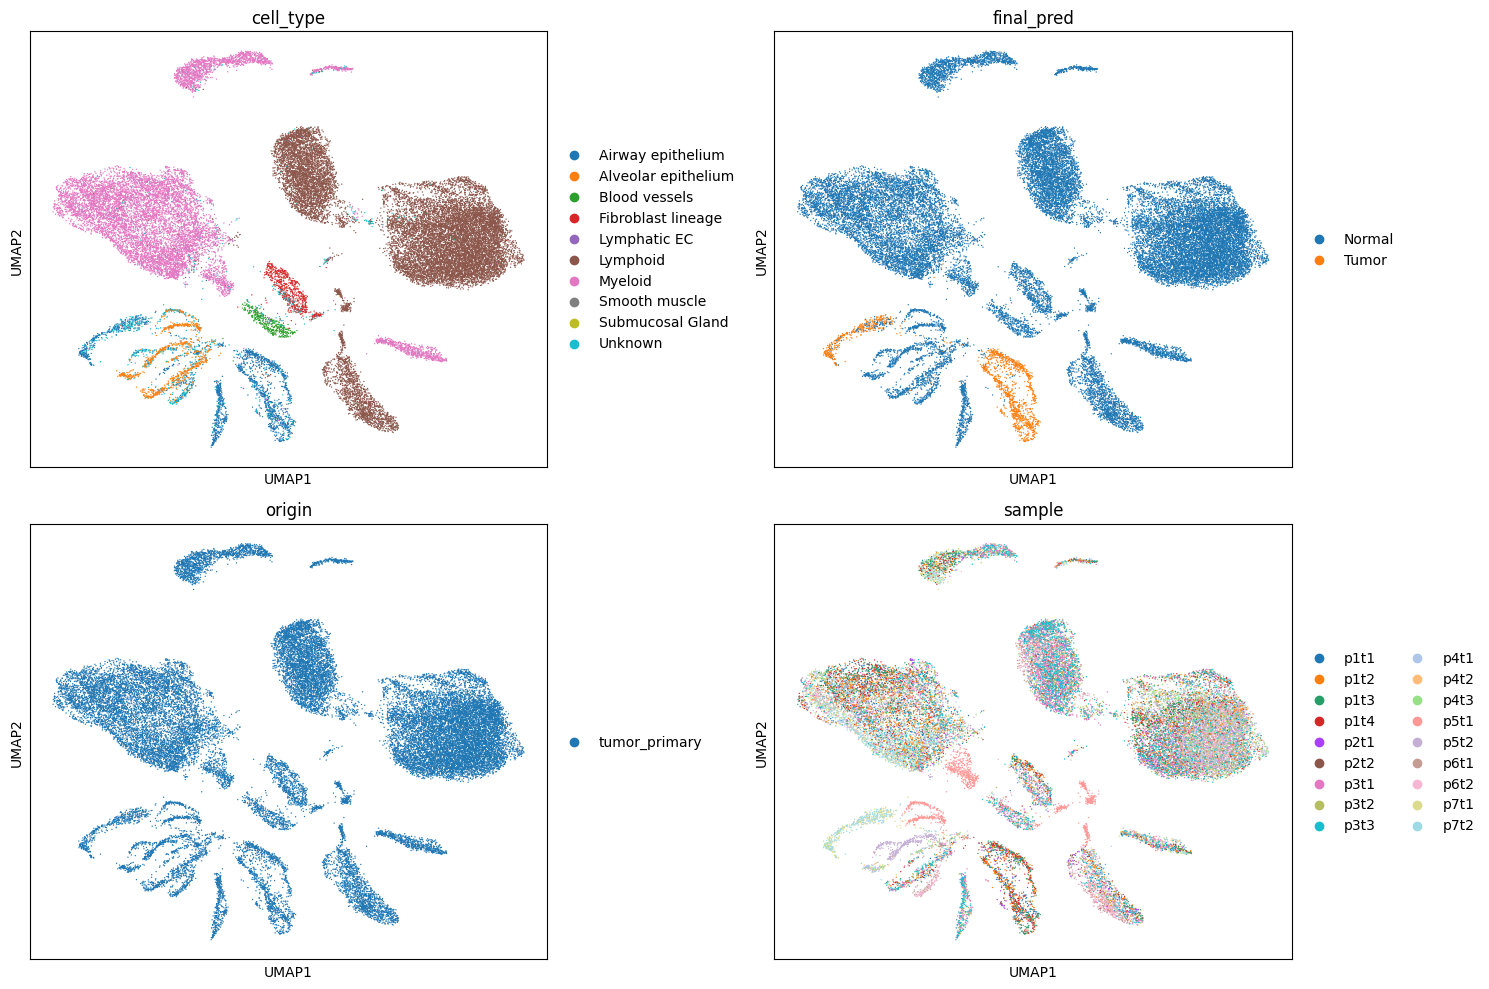

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sc.pl.umap(
    adata,
    color="cell_type",
    # legend_loc="on data",
    legend_fontoutline=2,
    ax=axs[0, 0],  # Specifies the subplot
    show=False  # Prevents showing the plot immediately
)

sc.pl.umap(
    adata,
    color="final_pred",
    # legend_loc="on data",
    legend_fontoutline=2,
    ax=axs[0, 1],  # Specifies the subplot
    show=False  # Prevents showing the plot immediately
)

sc.pl.umap(
    adata,
    color="origin",
    # legend_loc="on data",
    legend_fontoutline=2,
    ax=axs[1, 0],  # Specifies the subplot
    show=False  # Prevents showing the plot immediately
)

sc.pl.umap(
    adata,
    color="sample",
    # legend_loc="on data",
    legend_fontoutline=2,
    ax=axs[1, 1],  # Specifies the subplot
    show=False  # Prevents showing the plot immediately
)

# Display the entire figure with all plots
plt.tight_layout()
plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [16]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_120035/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
p1t1    2033
p1t2    2253
p1t3    1182
p1t4    1332
p2t1     200
p2t2     166
p3t1    2682
p3t2    2874
p3t3    2711
p4t1    1366
p4t2    1255
p4t3    1547
p5t1    1108
p5t2    2034
p6t1    2471
p6t2    2195
p7t1    2461
p7t2    2203
Name: gsm, dtype: int64

## Marker Genes

Create a column that merges cell type, tissue and tumor pred

In [17]:
adata.obs['type_tissue'] = adata.obs.apply(lambda x: str(x['cell_type']) + '_' + 
                 ('HT' if 'normal' in x['origin'] else 'TT') + 
                 '_' + x['final_pred'], axis=1)
adata.obs['type_tissue'] = adata.obs['type_tissue'].astype('category')
adata.obs['type_tissue']

0                   Lymphoid_TT_Normal
1          Airway epithelium_TT_Normal
2        Alveolar epithelium_TT_Normal
3          Airway epithelium_TT_Normal
4         Fibroblast lineage_TT_Normal
                     ...              
32068               Lymphoid_TT_Normal
32069      Airway epithelium_TT_Normal
32070               Lymphoid_TT_Normal
32071               Lymphoid_TT_Normal
32072                Myeloid_TT_Normal
Name: type_tissue, Length: 32073, dtype: category
Categories (16, object): ['Airway epithelium_TT_Normal', 'Airway epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal', 'Alveolar epithelium_TT_Tumor', ..., 'Smooth muscle_TT_Normal', 'Submucosal Gland_TT_Normal', 'Unknown_TT_Normal', 'Unknown_TT_Tumor']

In [18]:
# We dont get them with unique because it saves the NaN's
adata.obs.cell_type = adata.obs.cell_type.astype('category')
types = adata.obs.cell_type.cat.categories
num_types = len(types)
types

Index(['Airway epithelium', 'Alveolar epithelium', 'Blood vessels',
       'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid', 'Myeloid',
       'Smooth muscle', 'Submucosal Gland', 'Unknown'],
      dtype='object')

In [19]:
adata.obs['type_tissue'].value_counts()

type_tissue
Lymphoid_TT_Normal               17084
Myeloid_TT_Normal                10101
Airway epithelium_TT_Tumor        1256
Alveolar epithelium_TT_Normal      946
Unknown_TT_Normal                  773
Fibroblast lineage_TT_Normal       619
Airway epithelium_TT_Normal        618
Blood vessels_TT_Normal            359
Unknown_TT_Tumor                   195
Smooth muscle_TT_Normal             65
Lymphoid_TT_Tumor                   31
Lymphatic EC_TT_Normal              11
Myeloid_TT_Tumor                    10
Alveolar epithelium_TT_Tumor         2
Blood vessels_TT_Tumor               2
Submucosal Gland_TT_Normal           1
Name: count, dtype: int64

In [20]:
# Get the groups that have more than 2 cells associated with them
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = "wilcoxon",
                       groups=valid_types)

for type in types:
    tumor_tumor = type + '_TT_Tumor'
    normal_tumor = type + '_TT_Normal'
    normal_healthy = type + '_HT_Normal'
    
    if set([tumor_tumor, normal_tumor]).issubset(valid_types):
        sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = f"w_pair_{type}_differ",
                                groups=[tumor_tumor], reference=normal_tumor)
    if set([normal_tumor, normal_healthy]).issubset(valid_types):
        sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = f"w_pair_{type}_normal",
                                groups=[normal_tumor], reference=normal_healthy)

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [21]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    print(cond_types)
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

In [22]:
valid_types

['Lymphoid_TT_Normal',
 'Myeloid_TT_Normal',
 'Airway epithelium_TT_Tumor',
 'Alveolar epithelium_TT_Normal',
 'Unknown_TT_Normal',
 'Fibroblast lineage_TT_Normal',
 'Airway epithelium_TT_Normal',
 'Blood vessels_TT_Normal',
 'Unknown_TT_Tumor',
 'Smooth muscle_TT_Normal',
 'Lymphoid_TT_Tumor',
 'Lymphatic EC_TT_Normal',
 'Myeloid_TT_Tumor']

['Airway epithelium_TT_Tumor']
['Airway epithelium_TT_Tumor', 'Airway epithelium_TT_Normal']
['Alveolar epithelium_TT_Tumor']
['Alveolar epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal']
['Blood vessels_TT_Tumor']
['Blood vessels_TT_Tumor', 'Blood vessels_TT_Normal']
['Fibroblast lineage_TT_Tumor']
['Fibroblast lineage_TT_Tumor', 'Fibroblast lineage_TT_Normal']
['Lymphatic EC_TT_Tumor']
['Lymphatic EC_TT_Tumor', 'Lymphatic EC_TT_Normal']
['Lymphoid_TT_Tumor']
['Lymphoid_TT_Tumor', 'Lymphoid_TT_Normal']
['Myeloid_TT_Tumor']
['Myeloid_TT_Tumor', 'Myeloid_TT_Normal']


['Smooth muscle_TT_Tumor']
['Smooth muscle_TT_Tumor', 'Smooth muscle_TT_Normal']
['Submucosal Gland_TT_Tumor']
['Submucosal Gland_TT_Tumor', 'Submucosal Gland_TT_Normal']
['Unknown_TT_Tumor']
['Unknown_TT_Tumor', 'Unknown_TT_Normal']


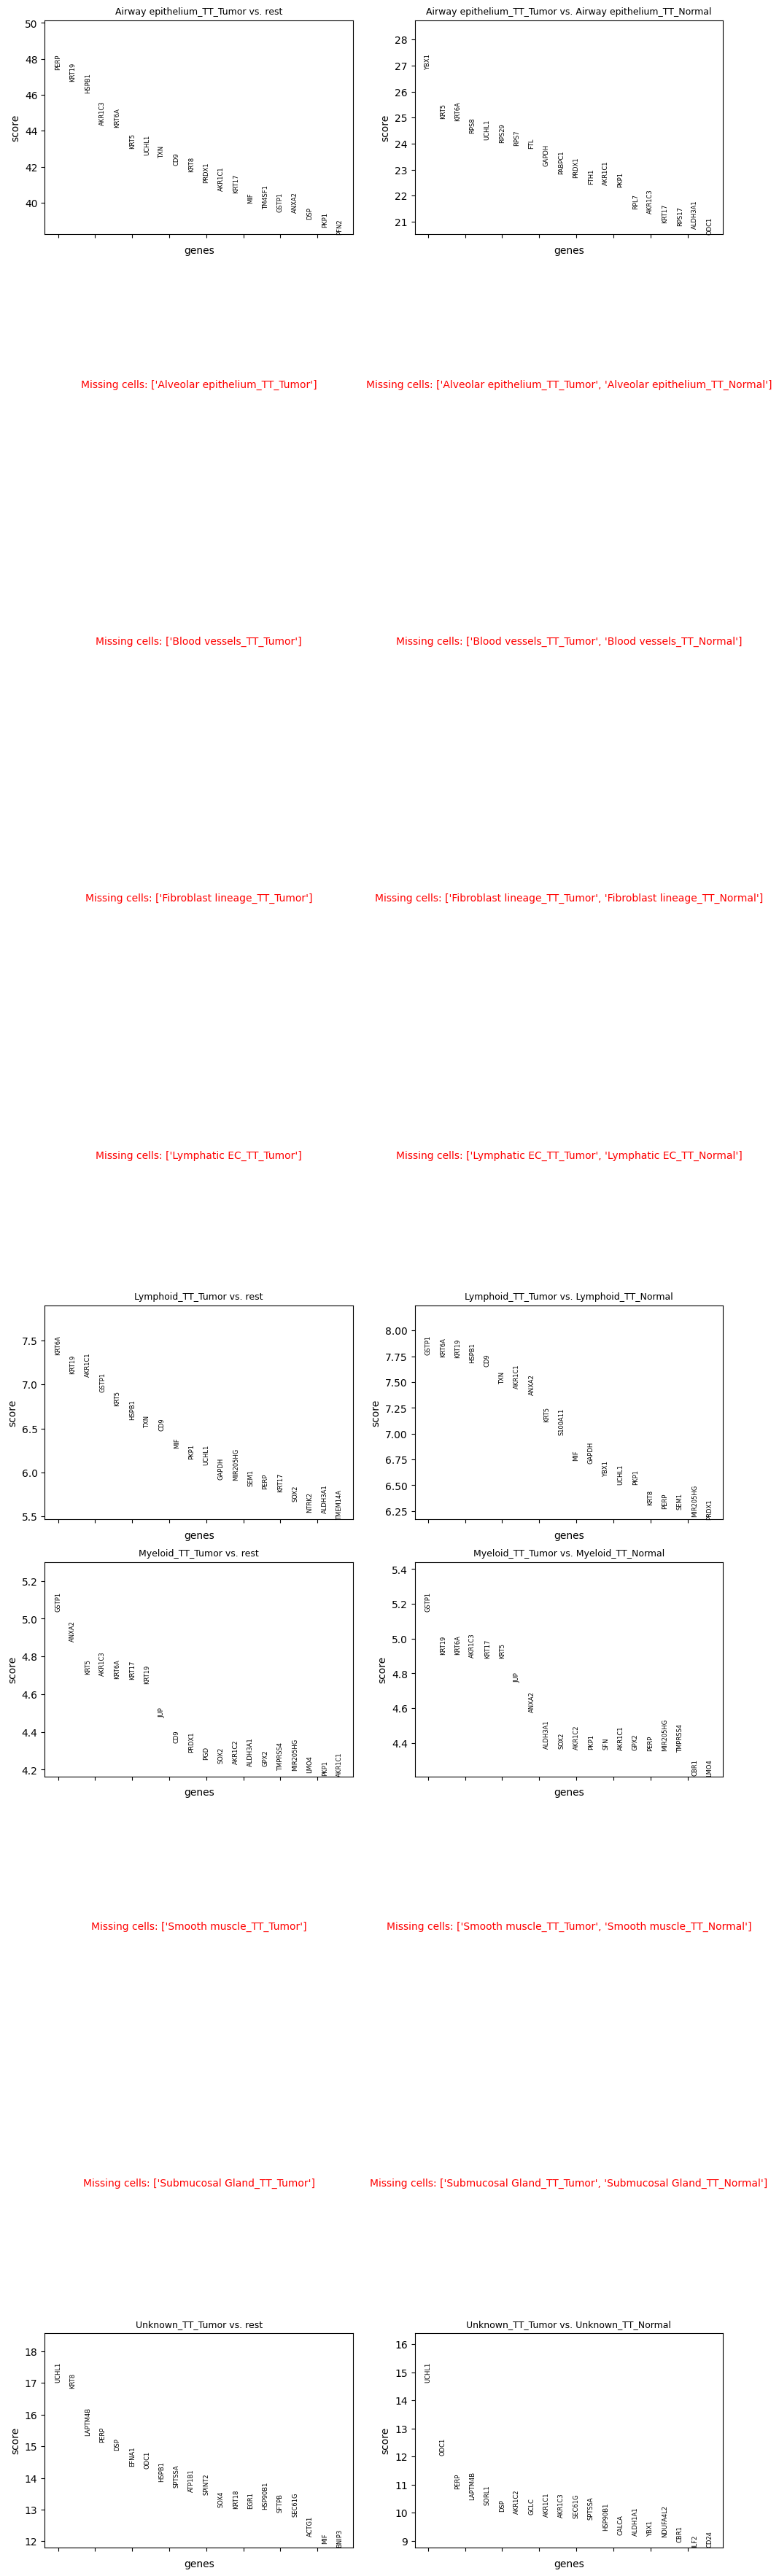

In [23]:
if(adata.obs.origin.str.contains('tumor').any()):
    fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        tumor_tumor = type + '_TT_Tumor'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [tumor_tumor], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
                                key=f"w_pair_{type}_differ", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    from warnings import warn
    warn('NO TUMOR TISSUES!?!?!?!!?')

In [24]:
adata.obs.origin.str.contains('normal').any()

False

In [25]:
from warnings import warn

if(adata.obs.origin.str.contains('normal').any()):
    fig, axs = plt.subplots(num_types, 3, figsize=(17, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        normal_healthy = type + '_HT_Normal'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [normal_healthy], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [normal_tumor], valid_types, n_genes=n_genes,
                                ax= axs[i, 1], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        print(f"w_pair_{type}_normal")
        cond_plot(adata, [normal_tumor, normal_healthy], valid_types, n_genes=n_genes, ax= axs[i, 2],
                                key=f"w_pair_{type}_normal", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    warn('No healthy tissue!')
    

/tmp/ipykernel_120035/3062282855.py:27: UserWarning: No healthy tissue!
  warn('No healthy tissue!')


## Heatmaps

categories: Airway epithelium_TT_Normal, Airway epithelium_TT_Tumor, Alveolar epithelium_TT_Normal, etc.
var_group_labels: Lymphoid_TT_Normal, Myeloid_TT_Normal, Airway epithelium_TT_Tumor, etc.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


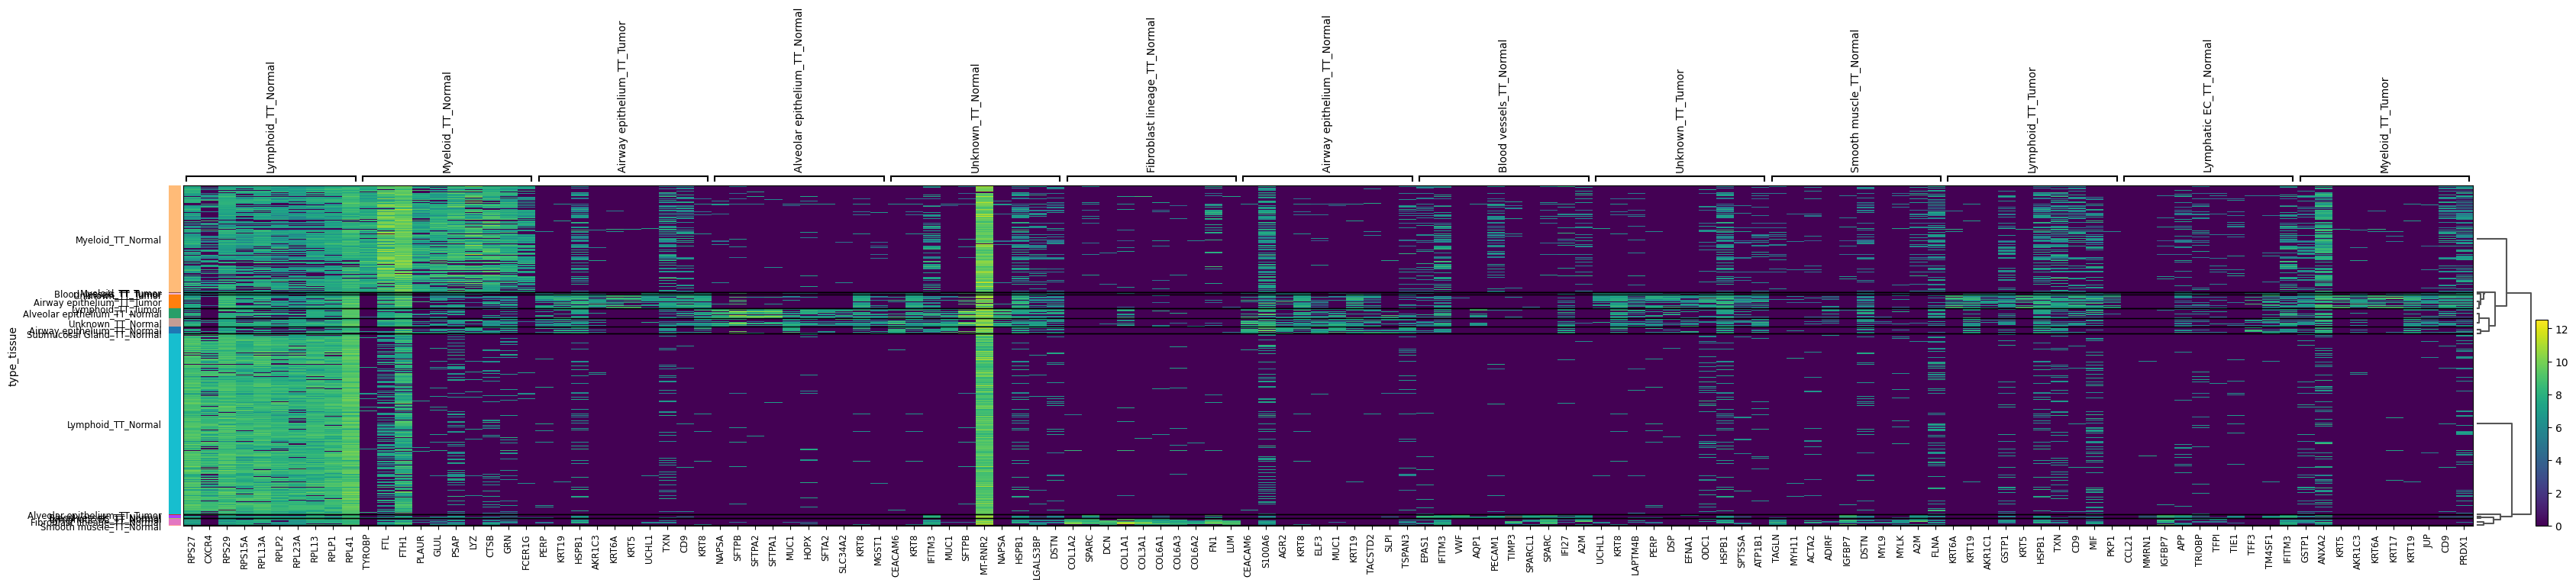

In [26]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [27]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [28]:
gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
enrich.iloc[:25,:]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0050789,regulation of biological process,4.940656e-324,True,"""Any process that modulates the frequency, rat...",12331,17065,11135,21010,0.652505,0.903009,query_1,"[GO:0008150, GO:0065007]"
1,GO:BP,GO:0051716,cellular response to stimulus,4.940656e-324,True,"""Any process that results in a change in state...",7399,17065,6997,21010,0.410021,0.945668,query_1,"[GO:0009987, GO:0050896]"
2,GO:BP,GO:0065007,biological regulation,4.940656e-324,True,"""Any process that modulates a measurable attri...",12751,17065,11526,21010,0.675418,0.903929,query_1,[GO:0008150]
3,GO:BP,GO:0050896,response to stimulus,4.940656e-324,True,"""Any process that results in a change in state...",8955,17065,8399,21010,0.492177,0.937912,query_1,[GO:0008150]
4,GO:BP,GO:0032501,multicellular organismal process,4.940656e-324,True,"""Any biological process, occurring at the leve...",7648,17065,7252,21010,0.424963,0.948222,query_1,[GO:0008150]
5,GO:BP,GO:0032502,developmental process,2.462899e-307,True,"""A biological process whose specific outcome i...",6414,17065,6102,21010,0.357574,0.951356,query_1,[GO:0008150]
6,GO:BP,GO:0007154,cell communication,8.075083e-299,True,"""Any process that mediates interactions betwee...",6495,17065,6162,21010,0.361090,0.948730,query_1,[GO:0009987]
7,GO:BP,GO:0048518,positive regulation of biological process,3.478660e-298,True,"""Any process that activates or increases the f...",6253,17065,5950,21010,0.348667,0.951543,query_1,"[GO:0008150, GO:0050789]"
8,GO:BP,GO:0050794,regulation of cellular process,5.815614e-294,True,"""Any process that modulates the frequency, rat...",11758,17065,10582,21010,0.620100,0.899983,query_1,"[GO:0009987, GO:0050789]"
9,GO:BP,GO:0048856,anatomical structure development,2.945093e-292,True,"""The biological process whose specific outcome...",5862,17065,5600,21010,0.328157,0.955305,query_1,[GO:0032502]


In [29]:
#  Download Gene symbols
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt
#  Gene entrez
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [30]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

In [31]:
types = adata.obs.loc[lambda x: x['final_pred']== 'Tumor' ]['type_tissue'].unique()
types = set(types).intersection(valid_types)

dfs = []

for type in types:
    wilco = adata.uns['wilcoxon']

    gene_scores = {gene: wilco['scores'][type][i] for i, gene in enumerate(wilco['names'][type])}
    gene_scores = pd.Series(gene_scores)

    # Run GSEA
    pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                         processes=20, permutation_num=100, # Adjust these as needed
                         outdir='gseapy_gsea', seed=6, no_plot=True)

    data1 = {'hallmark': list(pre_res.res2d['Term'].str.slice(9)), 'score': list(pre_res.res2d['NES'])}
    df_celltype1 = pd.DataFrame(data1)
    df_celltype1['cell_type'] = type
    dfs.append(df_celltype1)

    
combined_df = pd.concat(dfs).reset_index().pivot(index='cell_type', columns='hallmark', values='score')
    

/tmp/ipykernel_120035/814111951.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:44,377 [WARNING] Duplicated values found in preranked stats: 34.81% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/814111951.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:45,594 [WARNING] Duplicated values found in preranked stats: 60.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/814111951.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:46,847 [WARNING] Duplicated values found in preranked stats: 70.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/814111951.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:47,787 [WARNING] Duplicated values found in preranked stats: 45.44% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


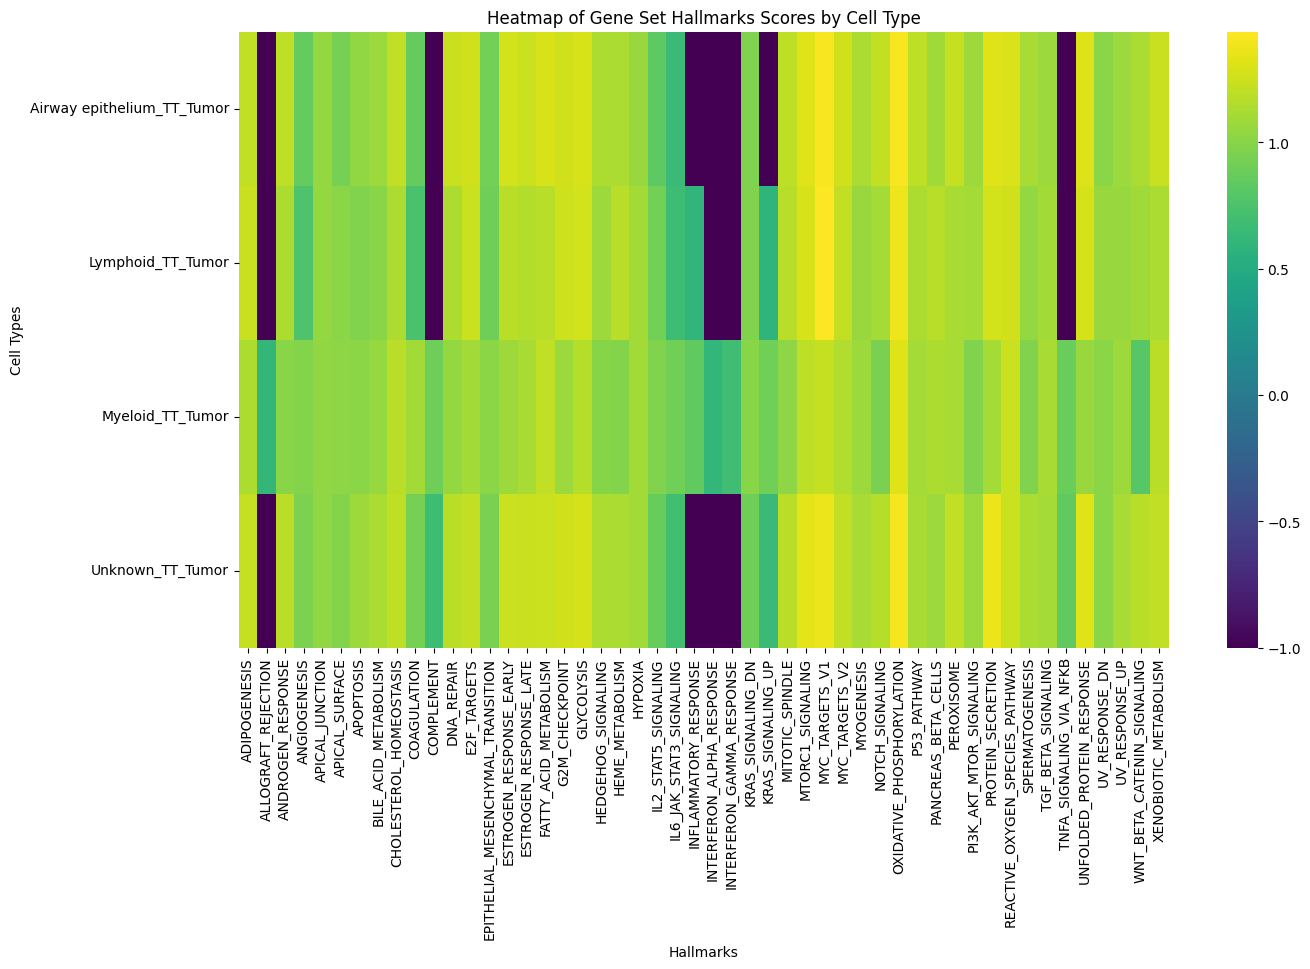

In [32]:
# Plotting the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()

In [33]:
types = adata.obs.loc[lambda x: x['final_pred']== 'Normal' ]['type_tissue'].unique()
types = set(types).intersection(valid_types)

dfs = []

for type in types:
    wilco = adata.uns['wilcoxon']

    gene_scores = {gene: wilco['scores'][type][i] for i, gene in enumerate(wilco['names'][type])}
    gene_scores = pd.Series(gene_scores)

    # Run GSEA
    pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                         processes=20, permutation_num=100, # Adjust these as needed
                         outdir='gseapy_gsea', seed=6, no_plot=True)

    data1 = {'hallmark': list(pre_res.res2d['Term'].str.slice(9)), 'score': list(pre_res.res2d['NES'])}
    df_celltype1 = pd.DataFrame(data1)
    df_celltype1['cell_type'] = type
    dfs.append(df_celltype1)

    
combined_df = pd.concat(dfs).reset_index().pivot(index='cell_type', columns='hallmark', values='score')
    

/tmp/ipykernel_120035/1273519738.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:50,182 [WARNING] Duplicated values found in preranked stats: 49.83% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/1273519738.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:51,219 [WARNING] Duplicated values found in preranked stats: 66.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/1273519738.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:52,165 [WARNING] Duplicated values found in preranked stats: 29.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/1273519738.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:53,211 [WARNING] Duplicated values found in preranked stats: 76.70% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/1273519738.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:54,354 [WARNING] Duplicated values found in preranked stats: 38.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/1273519738.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:55,294 [WARNING] Duplicated values found in preranked stats: 27.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/1273519738.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:56,377 [WARNING] Duplicated values found in preranked stats: 43.42% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/1273519738.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:57,268 [WARNING] Duplicated values found in preranked stats: 42.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_120035/1273519738.py:13: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 05:45:58,207 [WARNING] Duplicated values found in preranked stats: 40.43% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


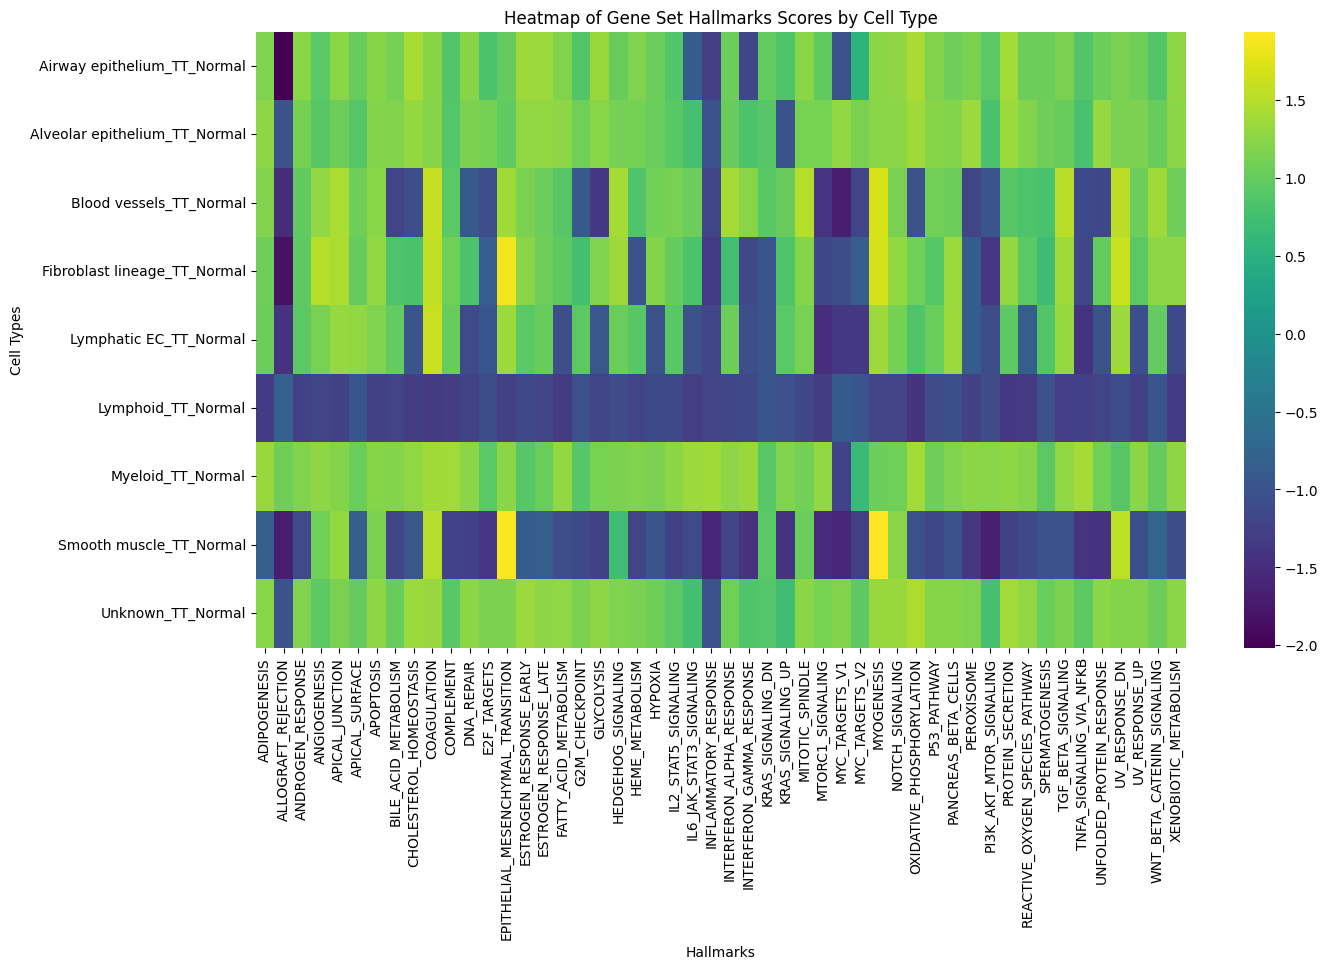

In [34]:
# Plotting the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()